# Desafio Tecnico FieldPro

## Setup

In [1]:
!pip install -q sklearn
!pip install -U plotly

     |████████████████████████████████| 13.2MB 257kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [2]:
%tensorflow_version 2.x

In [3]:
import pandas as pd
import tensorflow as tf
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt

In [4]:
estacao_path = '/content/drive/MyDrive/Colab Notebooks/Desafio Tecnico Dados FieldPro/Desafio Técnico Dados FieldPRO/Estacao_Convenvional.csv'
sensor_path = '/content/drive/MyDrive/Colab Notebooks/Desafio Tecnico Dados FieldPro/Desafio Técnico Dados FieldPRO/Sensor_FieldPRO.csv'

## Ler dataframes com Pandas

In [5]:
df_estacao = pd.read_csv(estacao_path)
df_estacao.head()

,data,Hora (Brasília),chuva
0,2020-09-01,00:00:00,0.0
1,2020-09-01,01:00:00,0.0
2,2020-09-01,02:00:00,0.0
3,2020-09-01,03:00:00,0.0
4,2020-09-01,04:00:00,0.0


In [6]:
df_sensor = pd.read_csv(sensor_path)
df_sensor.head()

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature
0,2020-09-30T23:00:00Z,38.0,31.366,9412,0,45123,30
1,2020-10-01T00:00:00Z,NaN,NaN,9412,0,45025,31
2,2020-10-01T01:00:00Z,39.0,31.366,9419,0,44923,31
3,2020-10-01T02:00:00Z,39.0,31.322,9419,0,44825,31
4,2020-10-01T03:00:00Z,38.0,31.240,9416,0,44728,31


## Unir os 2 dataframes em timestamp

In [7]:
df_estacao.index = pd.to_datetime(df_estacao.data + ' ' + df_estacao['Hora (Brasília)'])
df_estacao = df_estacao.drop(['data', 'Hora (Brasília)'], axis=1)
df_estacao.index.rename('datetime', inplace=True)
df_estacao.index = df_estacao.index.tz_localize('Etc/GMT-3')
df_estacao.head()

,chuva
datetime,
2020-09-01 00:00:00+03:00,0.0
2020-09-01 01:00:00+03:00,0.0
2020-09-01 02:00:00+03:00,0.0
2020-09-01 03:00:00+03:00,0.0
2020-09-01 04:00:00+03:00,0.0


In [8]:
df_sensor.index = pd.to_datetime(df_sensor['Datetime – utc'])
df_sensor = df_sensor.drop(['Datetime – utc'], axis=1)
df_sensor.index.rename('datetime', inplace=True)
df_sensor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1711 entries, 2020-09-30 23:00:00+00:00 to 2020-12-11 13:00:00+00:00
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   air_humidity_100     1705 non-null   float64
 1   air_temperature_100  1705 non-null   float64
 2   atm_pressure_main    1711 non-null   int64  
 3   num_of_resets        1711 non-null   int64  
 4   piezo_charge         1711 non-null   int64  
 5   piezo_temperature    1711 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 93.6 KB


In [9]:
df_sensor = df_sensor.dropna()
df_sensor.head()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature
datetime,,,,,,
2020-09-30 23:00:00+00:00,38.0,31.366,9412,0,45123,30
2020-10-01 01:00:00+00:00,39.0,31.366,9419,0,44923,31
2020-10-01 02:00:00+00:00,39.0,31.322,9419,0,44825,31
2020-10-01 03:00:00+00:00,38.0,31.240,9416,0,44728,31
2020-10-01 04:00:00+00:00,39.0,30.828,9411,0,44632,30


In [10]:
df_merged = pd.merge(df_sensor, df_estacao, left_index=True, right_index=True)
df_merged.head()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva
datetime,,,,,,,
2020-09-30 23:00:00+00:00,38.0,31.366,9412,0,45123,30,0.0
2020-10-01 01:00:00+00:00,39.0,31.366,9419,0,44923,31,0.0
2020-10-01 02:00:00+00:00,39.0,31.322,9419,0,44825,31,0.0
2020-10-01 03:00:00+00:00,38.0,31.240,9416,0,44728,31,0.0
2020-10-01 04:00:00+00:00,39.0,30.828,9411,0,44632,30,0.0


## Analise descritiva simples

In [54]:
df_merged.corr().chuva

air_humidity_100       0.056641
air_temperature_100   -0.034607
atm_pressure_main     -0.111490
num_of_resets          0.065083
piezo_charge          -0.015625
piezo_temperature     -0.034741
chuva                  1.000000
Name: chuva, dtype: float64

In [56]:
px.scatter_matrix(
    df_merged
).show()

As melhores correlações seriam de qualquer temperatura próxima de 20, e piezo charge próxima à 40k

In [13]:
df_merged.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
air_humidity_100,1519.0,58.557604,21.852070,13.00,39.50,59.00,78.00,99.000
air_temperature_100,1519.0,24.797488,6.308301,12.36,19.93,23.16,29.73,42.664
atm_pressure_main,1519.0,9432.515471,27.304478,9350.00,9415.00,9433.00,9451.50,9507.000
num_of_resets,1519.0,1.489138,1.038638,0.00,1.00,1.00,2.00,3.000
piezo_charge,1519.0,44229.429888,12662.425225,16950.00,34651.50,44041.00,55045.00,65533.000
piezo_temperature,1519.0,25.053983,8.529403,11.00,18.00,22.00,32.00,47.000
chuva,1519.0,0.092824,0.830604,0.00,0.00,0.00,0.00,16.800


In [14]:
train_df = df_merged.sample(frac=.8)
test_df = df_merged.drop(train_df.index)

In [15]:
train_df.describe()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva
count,1215.000000,1215.000000,1215.000000,1215.000000,1215.000000,1215.000000,1215.000000
mean,58.255967,24.842584,9432.488889,1.483128,44464.338272,25.116049,0.079671
std,21.921670,6.337625,27.604222,1.033780,12606.412422,8.564834,0.712589
min,13.000000,12.420000,9350.000000,0.000000,16950.000000,11.000000,0.000000
25%,39.000000,19.953000,9415.000000,1.000000,34942.000000,18.000000,0.000000
50%,58.000000,23.180000,9433.000000,1.000000,44295.000000,22.000000,0.000000
75%,77.000000,29.821000,9451.000000,2.000000,55408.000000,32.000000,0.000000
max,99.000000,42.664000,9507.000000,3.000000,65533.000000,47.000000,16.800000


In [16]:
test_df.describe()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva
count,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000
mean,59.763158,24.617250,9432.621711,1.513158,43290.569079,24.805921,0.145395
std,21.565232,6.196729,26.115856,1.059216,12862.013483,8.395651,1.190964
min,14.000000,12.360000,9354.000000,0.000000,17291.000000,12.000000,0.000000
25%,41.000000,19.725000,9416.000000,1.000000,34009.750000,18.000000,0.000000
50%,60.000000,22.954000,9434.000000,1.000000,42909.500000,22.000000,0.000000
75%,79.250000,29.555000,9452.000000,2.000000,54122.250000,32.000000,0.000000
max,97.000000,42.506000,9490.000000,3.000000,65431.000000,45.000000,15.200000


## Preparando os datasets para treinamento

In [17]:
train_features = train_df.copy()
test_features = test_df.copy()

train_labels = train_features.pop('chuva')
test_labels = test_features.pop('chuva')

In [18]:
features_array = np.array(train_features)

model_normalizer = tf.keras.layers.experimental.preprocessing.Normalization(input_shape=[6,])
model_normalizer.adapt(features_array)

## Modelo Linear

In [19]:
linear_model = tf.keras.Sequential([model_normalizer, tf.keras.layers.Dense(units=1)])
linear_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 20
Trainable params: 7
Non-trainable params: 13
_________________________________________________________________


In [20]:
linear_model.predict(train_features[:10])

array([[ 1.9924357 ],
       [-2.3294806 ],
       [ 1.6784495 ],
       [-0.02114041],
       [-1.3768206 ],
       [ 0.00309226],
       [ 1.7616019 ],
       [ 0.05945016],
       [ 0.02280213],
       [-1.7211416 ]], dtype=float32)

In [21]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [22]:
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=20,
    validation_split=0.2,
)

Epoch 1/20
31/31 [==============================] - 1s 23ms/step - loss: 0.4711 - val_loss: 0.1977
Epoch 2/20
31/31 [==============================] - 0s 2ms/step - loss: 0.1009 - val_loss: 0.1855
Epoch 3/20
31/31 [==============================] - 0s 2ms/step - loss: 0.0967 - val_loss: 0.1528
Epoch 4/20
31/31 [==============================] - 0s 3ms/step - loss: 0.1225 - val_loss: 0.1466
Epoch 5/20
31/31 [==============================] - 0s 3ms/step - loss: 0.1197 - val_loss: 0.1485
Epoch 6/20
31/31 [==============================] - 0s 3ms/step - loss: 0.1024 - val_loss: 0.1628
Epoch 7/20
31/31 [==============================] - 0s 2ms/step - loss: 0.1004 - val_loss: 0.1582
Epoch 8/20
31/31 [==============================] - 0s 2ms/step - loss: 0.1611 - val_loss: 0.1531
Epoch 9/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0735 - val_loss: 0.1429
Epoch 10/20
31/31 [==============================] - 0s 2ms/step - loss: 0.1012 - val_loss: 0.1675
Epoch 11/20
31/31 

In [23]:
pd.DataFrame(history.history).tail()

,loss,val_loss
15,0.099184,0.150159
16,0.094656,0.137402
17,0.090405,0.158669
18,0.100494,0.143243
19,0.095136,0.151573


In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

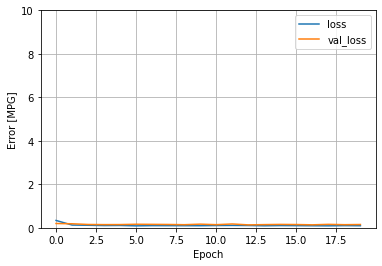

In [25]:
plot_loss(history)

In [26]:
test_result = linear_model.evaluate(test_features, test_labels)
test_result

10/10 [==============================] - 0s 1ms/step - loss: 0.1729


0.1728963404893875

In [27]:
samples = df_merged.sample(5)
samples

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva
datetime,,,,,,,
2020-11-24 05:00:00+00:00,55.0,21.080,9462,3,57378,19,0.0
2020-11-25 23:00:00+00:00,46.0,27.060,9423,3,53411,27,0.0
2020-10-04 06:00:00+00:00,74.0,19.620,9439,0,36392,18,0.0
2020-11-19 13:00:00+00:00,59.0,25.240,9430,2,33893,27,0.0
2020-10-05 22:00:00+00:00,47.0,27.824,9413,0,32700,29,0.0


In [28]:
samples.pop('chuva')
linear_model.predict(samples)

array([[ 0.04075698],
       [ 0.02072906],
       [ 0.00877703],
       [-0.01137685],
       [ 0.00848432]], dtype=float32)

### Testando predictions do modelo linear

In [37]:
lin_pred = linear_model.predict(test_features).flatten()
linear_test_df = pd.DataFrame({'labels': test_labels, 'predictions': lin_pred})
px.scatter(linear_test_df)

## Modelo DNN

In [29]:
dnn_model = tf.keras.Sequential([
    model_normalizer,
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1,),
])

dnn_model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,686
Trainable params: 4,673
Non-trainable params: 13
_________________________________________________________________


In [ ]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    epochs=100
)

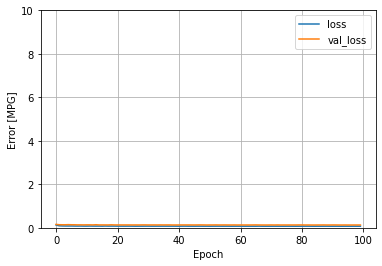

In [31]:
plot_loss(history)

In [32]:
dnn_test_results = dnn_model.evaluate(test_features, test_labels)

10/10 [==============================] - 0s 1ms/step - loss: 0.1495


DNN Mean Absolute Error

In [33]:
dnn_test_results

0.1495063304901123

### Testando predictions do modelo DNN

In [34]:
test_predictions = dnn_model.predict(test_features).flatten()

dnn_plot_df = pd.DataFrame({'labels': test_labels, 'predictions': test_predictions})

px.scatter(dnn_plot_df)

In [35]:
dnn_plot_df.query('predictions > .01')

,labels,predictions
datetime,,
2020-10-10 16:00:00+00:00,0.0,0.010201
2020-10-12 23:00:00+00:00,0.0,0.010644
2020-10-14 20:00:00+00:00,9.2,0.016223
2020-10-29 03:00:00+00:00,0.0,0.028423
2020-11-05 12:00:00+00:00,0.0,0.010950
2020-11-17 10:00:00+00:00,0.0,0.010348


In [47]:
train_df.query('chuva > 0').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
air_humidity_100,43.0,69.069767,19.950409,32.0,54.00,71.00,86.00,97.00
air_temperature_100,43.0,23.233628,4.804390,17.2,19.96,21.46,25.62,35.96
atm_pressure_main,43.0,9417.279070,24.954554,9370.0,9395.00,9421.00,9436.00,9464.00
num_of_resets,43.0,1.813953,0.852331,0.0,1.00,2.00,2.00,3.00
piezo_charge,43.0,42624.139535,9713.938127,23727.0,36272.00,38284.00,49300.50,62880.00
piezo_temperature,43.0,22.953488,6.462174,16.0,19.00,20.00,25.00,41.00
chuva,43.0,2.251163,3.110074,0.2,0.30,1.00,3.20,16.80


In [49]:
dnn_model.save('/content/drive/MyDrive/Colab Notebooks/Desafio Tecnico Dados FieldPro/dnn_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Desafio Tecnico Dados FieldPro/dnn_model/assets


In [50]:
linear_model.save('/content/drive/MyDrive/Colab Notebooks/Desafio Tecnico Dados FieldPro/linear_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Desafio Tecnico Dados FieldPro/linear_model/assets


## Conclusao

Nenhum dos 2 modelos se adequou muito bem aos dados, devido à minha falta de expêriencia na área de dados, eu não sou capaz de dizer a causa da falha